In [2]:
# DF 
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
from math import floor
from scipy.optimize import minimize

# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px # type: ignore
import plotly.graph_objs as go # type: ignore

# # time series
import yfinance as yf
from statsmodels.tsa.stattools import adfuller, kpss # Tests for stationarity
from statsmodels.tsa.statespace.sarimax import SARIMAX # Actual Model
from pmdarima.arima import auto_arima
import pmdarima
from statsmodels.tsa.seasonal import seasonal_decompose # Decomposing into trend, seasonal, residual
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Plotting (Partial) Autocorrelation
from statsmodels.tsa.stattools import acf, pacf # Calculating (Partial) Autocorrelation Functions
from scipy.stats import normaltest, boxcox # Tests if data came from a normal distribution, is a transformation

# Evaluation
from sklearn.metrics import mean_squared_error # A metric for evaluating a model
from sklearn.model_selection import train_test_split

# To ensure reproducability
import random

# To see progress
from tqdm import tqdm

# pipelines and regressions
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score


## Loading the data

In [3]:
stocks = pd.read_csv('sp500.csv')
stocks.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
idx = 269
ticker, company = stocks['Symbol'].iloc[idx], stocks['Security'].iloc[idx]
print(ticker, company)

JPM JPMorgan Chase


In [5]:
start_date = '2021-01-01'
end_date = date.today()

In [6]:
df = yf.download(ticker, start = start_date, end = end_date)
df.to_csv('data.csv')
df = pd.read_csv('data.csv')
df

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021-01-04,127.500000,127.860001,124.779999,125.870003,113.580315,16819900
1,2021-01-05,124.989998,126.300003,123.769997,125.650002,114.198349,13731200
2,2021-01-06,129.880005,132.770004,127.879997,131.550003,119.560616,24909100
3,2021-01-07,135.690002,138.190002,134.919998,135.869995,123.486885,21940400
4,2021-01-08,135.970001,136.350006,134.119995,136.020004,123.623222,12035100
...,...,...,...,...,...,...,...
884,2024-07-11,206.210007,208.100006,205.380005,207.449997,207.449997,10658100
885,2024-07-12,204.000000,207.449997,202.100006,204.940002,204.940002,15439700
886,2024-07-15,207.190002,211.610001,206.720001,210.050003,210.050003,10719700
887,2024-07-16,210.000000,213.740005,208.080002,213.619995,213.619995,11557000


In [7]:
df['Daily Returns'] = df['Close'].pct_change().fillna(0)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Returns
0,2021-01-04,127.500000,127.860001,124.779999,125.870003,113.580315,16819900,0.000000
1,2021-01-05,124.989998,126.300003,123.769997,125.650002,114.198349,13731200,-0.001748
2,2021-01-06,129.880005,132.770004,127.879997,131.550003,119.560616,24909100,0.046956
3,2021-01-07,135.690002,138.190002,134.919998,135.869995,123.486885,21940400,0.032839
4,2021-01-08,135.970001,136.350006,134.119995,136.020004,123.623222,12035100,0.001104


In [8]:
fig1 = px.histogram(df, x='Daily Returns', text_auto=True).update_layout(title=f"Daily Returns for {company}", yaxis_title='Frequency')
fig1.show()

### Feature Engineering

Important features in making a predictive model for financial data:
1. RSI: Relative Strength Index (measures the speed at which prices change; determines if its overbought or oversold)
2. MACD: Moving Average Convergence Distance (momentum oscillator to help identify potential buying/selling opportunities)

In [9]:
# calculating 14 day rsi
delta = df['Close'].diff()
gain= delta.copy()
loss = delta.copy()
gain[gain<0] = 0
loss[loss > 0] = 0
avg_gain = gain.rolling(window=14).mean()
avg_loss = np.abs(loss.rolling(window=14).mean())
rs = avg_gain/avg_loss
rsi = 100 - (100/(1+rs))

In [10]:
# MACD  
ema_12 = df['Close'].ewm(span=12, adjust=False).mean() #ema = estimated moving average, ewm = exponentially weighted moving average
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
macd = ema_26-ema_12

In [11]:
df['RSI'] = rsi
df['MACD']= macd
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Returns,RSI,MACD
884,2024-07-11,206.210007,208.100006,205.380005,207.449997,207.449997,10658100,-0.001684,67.420603,-2.820300
885,2024-07-12,204.000000,207.449997,202.100006,204.940002,204.940002,15439700,-0.012099,67.048116,-2.628314
886,2024-07-15,207.190002,211.610001,206.720001,210.050003,210.050003,10719700,0.024934,70.039436,-2.855580
887,2024-07-16,210.000000,213.740005,208.080002,213.619995,213.619995,11557000,0.016996,75.383562,-3.285881
888,2024-07-17,213.800003,217.559998,213.270004,216.869995,216.869995,11564100,0.015214,79.241863,-3.844825


### Model Training

In [12]:
X = df[['RSI', 'MACD']]
y = np.where(df['Close'].shift(-1) > df['Close'], 1, -1)

# split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train in histogram gradient boosting classifier model
model = HistGradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)

pred = model.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print(f"Model Accuracy: {accuracy}")

Model Accuracy: 0.5280898876404494


### Model Evaluation

In [13]:
df['Predicted Signal'] = model.predict(X)
df['Strategy Returns'] = df['Daily Returns']*df['Predicted Signal'].shift()
df['Cumulative Returns'] = (1+df['Strategy Returns']).cumprod()

In [14]:
fig2 = px.line(df, x='Date', y='Cumulative Returns').update_layout(title = f'Cumulative Returns of the Trading Strategy for {company}')
fig2

## Data Preprocessing and Selection

In [15]:
df1 = df[['Date', 'Adj Close']]
df1.head()

,Date,Adj Close
0,2021-01-04,113.580315
1,2021-01-05,114.198349
2,2021-01-06,119.560616
3,2021-01-07,123.486885
4,2021-01-08,123.623222


In [16]:
train_split = floor(0.8*df['Adj Close'].size)
y_train, y_test = df1['Adj Close'].iloc[:train_split], df1['Adj Close'].iloc[train_split:]

### Visualization

In [17]:
# line plot
fig3 = px.line(df1, x='Date', y='Adj Close')
fig3.update_layout(title = f'Stock Price for {company}')
fig3

In [18]:
# The Augmented Dickey-Fuller Test
# Statistical hypothesis test that helps assess stationarity. Null hypothesis: Time series is not stationary
def adf_results(time_series):
    # Use the statsmodels implementation of ADF test
    result = adfuller(time_series)

    # Print results
    print('ADF Statistic: {}\np-value: {}\nCritical Values: {}'.format(result[0], result[1], result[4]))

    # Based on p-value, can determine if stationary
    stationary = (result[1] <= 0.05)
    
    # Conditionally adds the word not
    print('Result is stationary' if stationary else 'Result is NOT stationary')

In [19]:
adf_results(y_train)


ADF Statistic: -2.2411667120903545
p-value: 0.19164487438325756
Critical Values: {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}
Result is NOT stationary


In [20]:
kpss(y_train)


(0.6914396631479848,
 0.014323666986546838,
 17,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [21]:
diffs = y_train.diff().dropna()
# # Line plot
fig4 = px.line(diffs)
fig4

# Title
fig4.update_layout(title=f"Change in Stock Price for {company}")

# Display the plot
fig4.show()

In [22]:
adf_results(diffs)

ADF Statistic: -24.96828843156056
p-value: 0.0
Critical Values: {'1%': -3.439606888036868, '5%': -2.865625121924057, '10%': -2.5689454046801052}
Result is stationary


In [23]:
kpss(diffs)

C:\Users\namit\AppData\Local\Temp\ipykernel_12784\3900313453.py:1: InterpolationWarning:

The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.




(0.10760052959305999,
 0.1,
 4,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

### Autocorrelation and Partial Correlation Functions (ACF/PACF)

**ACF**: measures how a time series is related to its past values over different time lags, helping identify patterns such as trends/repeated cycles. It shows the strength and direction of correlation between the time series and its lagged values.

**PACF**: measures the direct relationship between a time series and its past values at specific lags, excluding the effects of intervening lags. This helps identify which lags have the most direct influence on the current values of the series.

<Axes: >

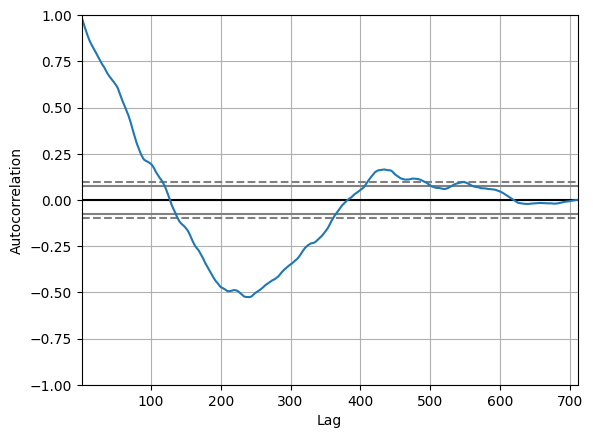

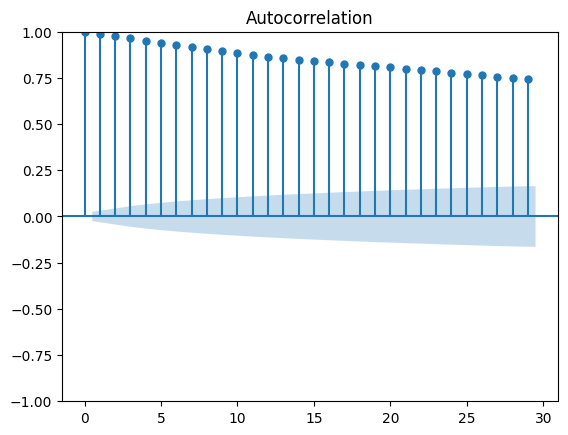

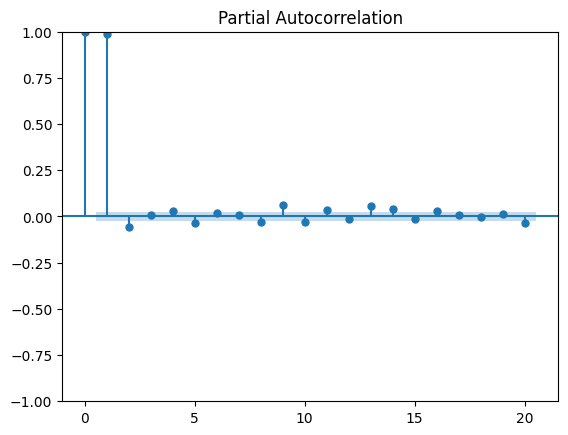

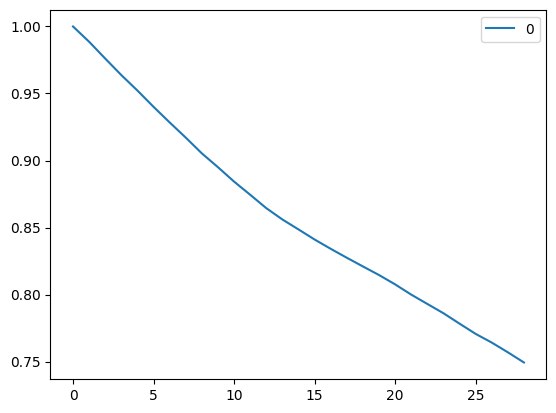

In [25]:
# Autocorrelation and Partial correlation functions (ACF/PACF)
# slow decline of ACF: imply trend, slow decline of PCf: imply seasonality
pd.plotting.autocorrelation_plot(y_train)
plot_acf(y_train, alpha=0.5)
plot_pacf(y_train, lags=20, alpha=0.5) #lag: number of time steps back from current time step
pd.DataFrame(pmdarima.utils.acf(y_train)).plot()

### Further Data Examination

c:\Users\namit\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\utils\visualization.py:220: FutureWarning:

the 'unbiased'' keyword is deprecated, use 'adjusted' instead.



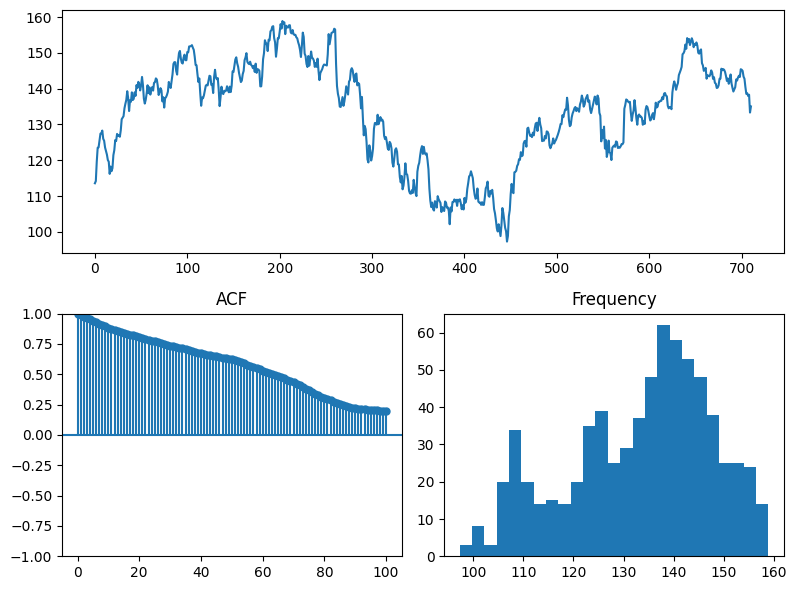

In [26]:
pmdarima.utils.tsdisplay(y_train, lag_max=100)

## Fitting with Auto-ARIMA model

**ARIMA (AutoRegressive Integrated Moving Average)**: a time series forecasting model that combines auto-regression (AR), differencing of values to achieve stationarity (I), and moving averages (MA) to predict future values. It models values using past values and forecast errors in the data to make predictions.

**AUTO-ARIMA**: automatically finds the best parameters for an ARIMA model by testing different combinations of parameters to fit the time series data, which simplifies the process of time series forecasting (since we don't have to manually find optimal parameters).

In [27]:
auto = pmdarima.auto_arima(y_train, seasonal=True, stepwise=True, start_p=2,
                           suppress_warnings=True, error_action='ignore',
                           max_q=3, max_order=None, trace=True, n_jobs=-1)

c:\Users\namit\AppData\Local\Programs\Python\Python39\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning:

stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3012.426, Time=1.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3014.694, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3013.930, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3014.045, Time=0.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3012.854, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3017.166, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3017.288, Time=0.38 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=3013.003, Time=1.77 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3013.042, Time=1.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3015.739, Time=0.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3018.996, Time=0.75 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=3019.141, Time=0.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=3016.172, Time=2.55 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=3010.577, Time=0.84 sec
 ARIMA(1,1,2)(0,0,0)[0]          

In [30]:
print(auto.order)
print(auto.seasonal_order)

full_model_name = auto.__str__().strip()
print(auto.params())

(2, 1, 2)
(0, 0, 0, 0)
ar.L1    -1.522512
ar.L2    -0.917427
ma.L1     1.554776
ma.L2     0.965725
sigma2    4.005631
dtype: float64


In [33]:
import pmdarima.metrics

model = auto
long_term, lt_ci = model.predict(n_periods = y_test.size, return_conf_int = True)
lt_forecast_mse = mean_squared_error(y_test, long_term)
lt_forecast_smape = pmdarima.metrics.smape(y_test, long_term)

def forecast():
    fc, ci = model.predict(n_periods=1, return_conf_int=True)
    return (
        fc.tolist()[0], 
        np.asarray(ci).tolist()[0]
    )

forecasts = []
ci = []

for new in tqdm(y_test):
    fc, conf = forecast()
    forecasts.append(fc)
    ci.append(conf)
    model.update(new)


conf_interval = np.array(ci)
forecast_mse = mean_squared_error(y_test, forecasts)
forecast_smape = pmdarima.metrics.smape(y_test, forecasts)
print(f"MSE: {forecast_mse}")
print(f"SMAPE: {forecast_smape}")



  0%|          | 0/178 [00:00<?, ?it/s]

100%|██████████| 178/178 [00:30<00:00,  5.76it/s]

MSE: 6.7761841351547565
SMAPE: 0.9110540176830418


In [47]:
graph1 = go.Figure([
    go.Scatter(
        name = 'Actual Price',
        x = df['Date'],
        y= df['Adj Close'],
        mode='lines',
        marker = dict(color='#444'),
        line = dict(color='rgb(31, 119, 180)')
    ),
    go.Scatter(
        name='One-Step Forecasted Price', 
        x = df['Date'].iloc[train_split:], 
        y = forecasts,
        mode='lines',
        marker=dict(color='#444'),
        line = dict(color='rgb(180, 31, 31, 0.5)')
    ),
    go.Scatter(
        name='Upper-Bound', 
        x = df['Date'].iloc[train_split:], 
        y = conf_interval[:,1],
        mode='lines',
        marker=dict(color='#444'),
        line = dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower-Bound', 
        x = df['Date'].iloc[train_split:], 
        y = conf_interval[:,0],
        marker=dict(color='#444'),
        line = dict(width=0),
        mode='lines',
        fillcolor = 'rgba(68, 68, 0.3)',
        fill = 'tonexty',
        showlegend=False
    )    
])

graph1.update_layout(
    yaxis_title = 'Stock Price ($)<br><sup> Adjusted Close</sup>',
    xaxis_title = 'Date/Time',
    title = f'<b>{company} ({ticker}) Stock Price Forecast </b><br> One-Step Ahead Forecasting with {full_model_name} Model, MSE: {forecast_mse:.2f}, sMAPE: {forecast_smape:.2f}</br>',
    title_x = 0.5,
    hovermode = 'x'
)

In this model, we used short term forecasting (end of each day) to predict the next day's value. This leads to more accurate predictions in the long run - however, with long term forecasting, this approaches an unknown constant value (straight line). This implies that with our long term forecasts, it will follow a pattern of seasonality.

In [50]:
graph2 = go.Figure([
    go.Scatter(
        name = 'Actual Price',
        x = df['Date'],
        y= df['Adj Close'],
        mode='lines',
        marker = dict(color='#444'),
        line = dict(color='rgb(31, 119, 180)')
    ),
    go.Scatter(
        name='Long-Term Forecasted Price', 
        x = df['Date'].iloc[train_split:], 
        y = long_term,
        mode='lines',
        marker=dict(color='#444'),
        line = dict(color='rgb(180, 31, 31, 0.5)')
    ),
    go.Scatter(
        name='Upper-Bound', 
        x = df['Date'].iloc[train_split:], 
        y = lt_ci[:,1],
        mode='lines',
        marker=dict(color='#444'),
        line = dict(width=0),
        showlegend=False
    ),
    go.Scatter(
        name='Lower-Bound', 
        x = df['Date'].iloc[train_split:], 
        y = lt_ci[:,0],
        marker=dict(color='#444'),
        line = dict(width=0),
        mode='lines',
        fillcolor = 'rgba(68, 68, 0.3)',
        fill = 'tonexty',
        showlegend=False
    )    
])

graph2.update_layout(
    yaxis_title = 'Stock Price ($)<br><sup> Adjusted Close</sup>',
    xaxis_title = 'Date/Time',
    title = f'<b>{company} ({ticker}) Stock Price Forecast </b><br> Long-Term Forecasting with {full_model_name} Model, MSE: {forecast_mse:.2f}, sMAPE: {forecast_smape:.2f}</br>',
    title_x = 0.5,
    hovermode = 'x'
)

# Portfolio and Risk Management Test

In [51]:
tickers = ['CL', 'AAPL', 'MSFT', 'GOOG']
dataset = yf.download(tickers, start=start_date, end=end_date)['Adj Close']

[*********************100%%**********************]  4 of 4 completed


In [53]:
total_days = (dataset.index[-1] - dataset.index[0]).days
total_years = total_days / 365.25
avg_days_open = len(dataset) / total_years
returns = dataset.pct_change().dropna()
expected_returns = returns.mean()*avg_days_open
cov_matrix = returns.cov()*avg_days_open

In [54]:
def portfolio_performance(weights, expected_returns, cov_matrix):
    returns = np.dot(weights, expected_returns)
    std_dev = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return returns, std_dev

def neg_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate=0.01):
    returns, std_dev = portfolio_performance(weights, expected_returns, cov_matrix)
    return -(returns - risk_free_rate) / std_dev

def optimize_portfolio(expected_returns, cov_matrix):
    num_assets = len(expected_returns)
    args = (expected_returns, cov_matrix)
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = tuple((0, 1) for asset in range(num_assets))
    result = minimize(neg_sharpe_ratio, num_assets * [1. / num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result


In [55]:
# optimum results
opt_result = optimize_portfolio(expected_returns, cov_matrix)
opt_weights = opt_result.x
opt_return, opt_std_dev = portfolio_performance(opt_weights, expected_returns, cov_matrix)
opt_sharpe_ratio = (opt_return - 0.01) / opt_std_dev


In [56]:
# Display results
print("Optimal Weights: ", opt_weights)
print("Expected Portfolio Return: ", opt_return)
print("Expected Portfolio Volatility: ", opt_std_dev)
print("Sharpe Ratio: ", opt_sharpe_ratio)

Optimal Weights:  [0.06415782 0.32168434 0.21602974 0.3981281 ]
Expected Portfolio Return:  0.19445594832137786
Expected Portfolio Volatility:  0.19215644832176507
Sharpe Ratio:  0.959925882958178


In [57]:

def plot_efficient_frontier(expected_returns, cov_matrix, num_portfolios=10000, risk_free_rate=0.01):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(expected_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_return, portfolio_std_dev = portfolio_performance(weights, expected_returns, cov_matrix)
        results[0,i] = portfolio_return
        results[1,i] = portfolio_std_dev
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    
    results_df = pd.DataFrame({
        'Returns': results[0, :],
        'Volatility': results[1, :],
        'Sharpe Ratio': results[2, :]
    })

    fig = px.scatter(
        results_df,
        x='Volatility',
        y='Returns',
        color='Sharpe Ratio',
        color_continuous_scale='YlGnBu',
        title='Efficient Frontier',
        labels={'Volatility': 'Risk (Standard Deviation)', 'Returns': 'Expected Returns'}
    )
    
    opt_return, opt_std_dev = portfolio_performance(opt_weights, expected_returns, cov_matrix)
    fig.add_scatter(x=[opt_std_dev], y=[opt_return], mode='markers', marker=dict(color='red', size=15), name='Optimal Portfolio')

    fig.update_layout(
        title={
            'text': "Efficient Frontier",
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title="Volatility (Risk)",
        yaxis_title="Expected Returns",
        font=dict(
            family="Courier New, monospace",
            size=12,
            color="RebeccaPurple"
        )
    )

    fig.show()

In [58]:
plot_efficient_frontier(expected_returns, cov_matrix)
